# Fanal, a neutrino-less beta decay experiment 

## An open exercise

##  Sentitivity of the experiment

### USC, Master de Física, Física de Partícula II


J. A. Hernando-Morata, with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz

February 2021 - February 2022


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD THE FOLDER TO PYTHONPATH
import os
import sys
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Objective:

**Validate the method to compute the number of signal events**.

### Tasks

   * Open the data file (HDF) and access the simulated data (MC) of 214Bi, 208Tl and bb0nu. 

   * Generate experiments with a given number of signal events and a level of background compatible with the one estimated using the blind-data sample (in previous task).

   * Ensure that the estimation of your signal is correct in different signal scenarios. 
     * Consider for example the case where the signal events are equal to Bi.

   * Try to estimate the uncertainties on the number of signal events.

   * Estimate the half-life for different number signal scenarios.

## Notes

  * To valide a fit, usually we generate a large number of experiments with known true parameters; estimate the parameters, and study their distributions.
  
  * In the case of 'gaussian' limits, these distributions are gaussian, centered in the true value of the parameters and their standard deviations are the uncertentities of the parameters.


### The evil is in the details:

Here we are going to generate n-experiments with the number background events compatible with the values obtained using the blind-data (previous section) and several scenarios of possible number of signal events.

We aply the selection to each experiment data. Here we use the fanal selection, except that we do not apply the last cut, the refined energy region (RoI). Then we fit the energy distribution of the selected data to a combined PDF obtained from the three MC samples (bb0nu, Bi, Tl) in which we have previously applied the selection. 

A trick has been used: as the blob-energy and the event energy are uncorrelated, we have used  the event energy distributions obtained before the blob-energy cut as templates for the PDFs. If we have a large MC statistics we do not need this trick.



## Main parameters

In [5]:
coll   = 'test_alpha'
erange = fn.erange
eroi   = fn.eroi 
eblob2 = fn.eblob2

print('Data From               : {:s}'.format(coll))
print('Energy range            : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Blob-2 energy threshold : {:6.3f} MeV'.format(eblob2))
print('Energy RoI range        : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Data From               : test_alpha
Energy range            : ( 2.400,  2.700) MeV
Blob-2 energy threshold :  0.400 MeV
Energy RoI range        : ( 2.430,  2.480) MeV


## Access the data

In [6]:
dirpath = '/Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/'
filename = 'fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_test_alpha.h5


In [7]:
samples  = ['bb0nu', 'Bi', 'Tl']
ssamples = [r'$\beta\beta0\nu$', r'$^{214}$Bi', r'$^{208}$Tl']
mcs      = [mcbb, mcbi, mctl]

## Generate a MC experiment

### Estimate the number of events

In [8]:
from collpars import nevts_Bi, nevts_Tl, nevts_Bi_RoI, nevts_Tl_RoI
from collpars import unevts_Bi, unevts_Tl
from collpars import eff_bb_RoI

nbb_roi = nevts_Bi_RoI

nevts   = (nbb_roi/eff_bb_RoI, nevts_Bi, nevts_Tl)
print('Total number of events :', *['{:s} \t {:6.1f},'.format(s, ni) for s, ni in zip(samples, nevts)])

Total number of events : bb0nu 	    4.4, Bi 	  147.8, Tl 	 1116.3,


### Generate MC experiment

In [9]:
mdat = fn.generate_mc_experiment(mcs, nevts)

### The energy PDF distributions for each MC sample after selection

In [10]:
anadat, anamcs, effs = fn.ana_samples(mdat, mcs)

selection variables  : ['E', 'num_tracks', 'blob2_E']
selection ranges     : [(2.4, 2.65), (1.0, 1.1), (0.4, inf)]
selection mc samples : ['E', 'num_tracks']
data size            : 18
mc sizes             : [30217, 6688, 31607]
efficiencies         :   0.52, 1.76e-02, 7.28e-03


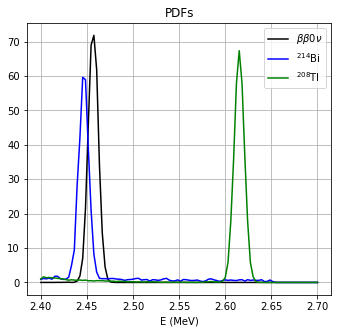

In [11]:
bins     = 100
varname  = 'E'
varrange = erange # E-range 
pdfs     = [stats.rv_histogram(np.histogram(mc[varname], bins, varrange)) for mc in anamcs]
xs       = np.linspace(*varrange, bins)

subplot = pltext.canvas(1); subplot(1);
for i, pdf in enumerate(pdfs): 
    plt.plot(xs, pdf.pdf(xs), label = ssamples[i])
plt.grid(); plt.legend(); 
plt.xlabel('E (MeV)'); plt.title('PDFs');

## Fit to the 3 samples: estimate the number of signal events


 The *ana_experiment* in the *fanal* module does the analysis:
 
  1. Selects the data and the MC-samples. It uses fanal selection (E-range, 1-track, blob2 > 0.4 MeV).
  
  2. Creates the Composide PDF with the MC-selected samples for the energy.
  
  3. Fits the energy of selected data to the composite PDF.
  
  4. Returns the fit results, the energy values, the ExtComPDF object, and the efficiencies of the selection in MC 



selection variables  : ['E', 'num_tracks', 'blob2_E']
selection ranges     : [(2.4, 2.65), (1.0, 1.1), (0.4, inf)]
selection mc samples : ['E', 'num_tracks']
data size            : 18
mc sizes             : [30217, 6688, 31607]
efficiencies         :   0.52, 1.76e-02, 7.28e-03
Initial       Events :   2.29,   2.60,   8.13
Fit success          :  True
Estimated     Events :   1.77,   0.00,  16.23


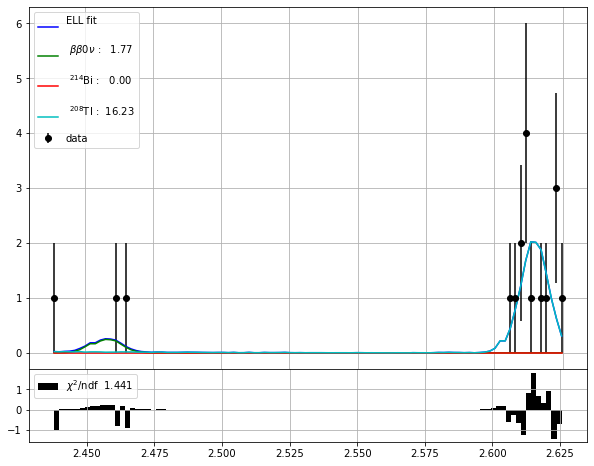

In [12]:
#  do the analysis
res, ene, ell, pdfs = fn.ana_experiment(mdat, mcs, nevts)
ns_est = res.x 

In [13]:
# inspect the result of the fit
res

      fun: -104.86269207686556
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.52651283e-06,  3.55356633e-01, -4.26325641e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 36
      nit: 8
   status: 0
  success: True
        x: array([ 1.76542781,  0.        , 16.23454299])

### Generate n-experiments in different signal scenarios.

Generate n-experiments (1000) with different 0bbnu events, for example 100, 10, 2 events in the RoI. 

Be careful with the case of very few bb0nu events in the RoI.

Get the distribution of the estimated number of events. 

Estimate the number of events uncertainties for each scenario

In [14]:
### Compute the efficiencies in the E-range of the fit for Bi, Tl

In [15]:
selnames  = ['E', 'num_tracks', 'blob2_E']
selranges = [erange, (1., 1.1), (eblob2, 1.2)]
eff_Bi_fit = ut.efficiency(fn.selection(mcbi, selnames, selranges))[0] 
eff_Tl_fit = ut.efficiency(fn.selection(mctl, selnames, selranges))[0] 

In [16]:
def experiments(mcs, size, nevts, ssamples = ssamples, plot = True):
            
    mevts  = []
    for i in range(size):
        mdat               = fn.generate_mc_experiment(mcs, nevts)
        res, enes, ell, _  = fn.ana_experiment(mdat, mcs, nevts, verbose = False)
        if (res.success == True): mevts.append(res.x)
            
    def _plot():
        subplot = pltext.canvas(4)
        for i in range(3):
            subplot(i + 1)
            nn = [m[i] for m in mevts]
            pltext.hist(nn, 100);
            plt.xlabel('number events');
            plt.title(ssamples[i])
        plt.tight_layout()

    if (plot): _plot()
    return mevts  

Total events           : 44.142581888246625 147.773 1116.288
Expected Events in fit : 22.91 2.6591479296823075 8.145218617278994


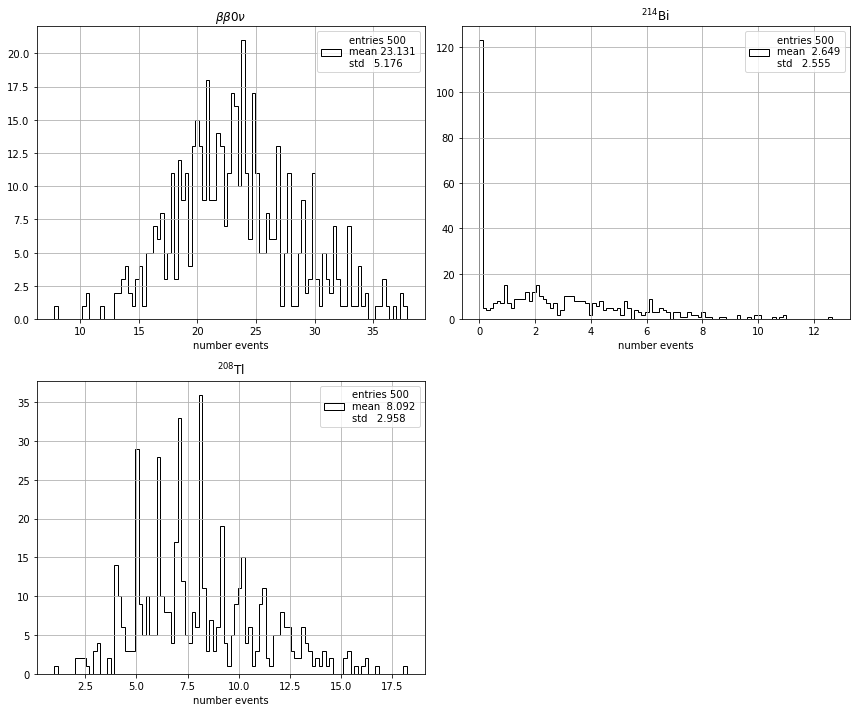

In [17]:
size      = 500
nbb_roi   = 10. * nevts_Bi_RoI
nevts_fit = (nbb_roi, nevts_Bi * eff_Bi_fit, nevts_Tl * eff_Tl_fit)
nevts     = (nbb_roi/eff_bb_RoI, nevts_Bi, nevts_Tl)
print('Total events           :', *nevts)
print('Expected Events in fit :', *nevts_fit)
mevts   = experiments(mcs, size, nevts)

Total events           : 4.414258188824663 147.773 1116.288
Expected Events in fit : 2.291 2.6591479296823075 8.145218617278994


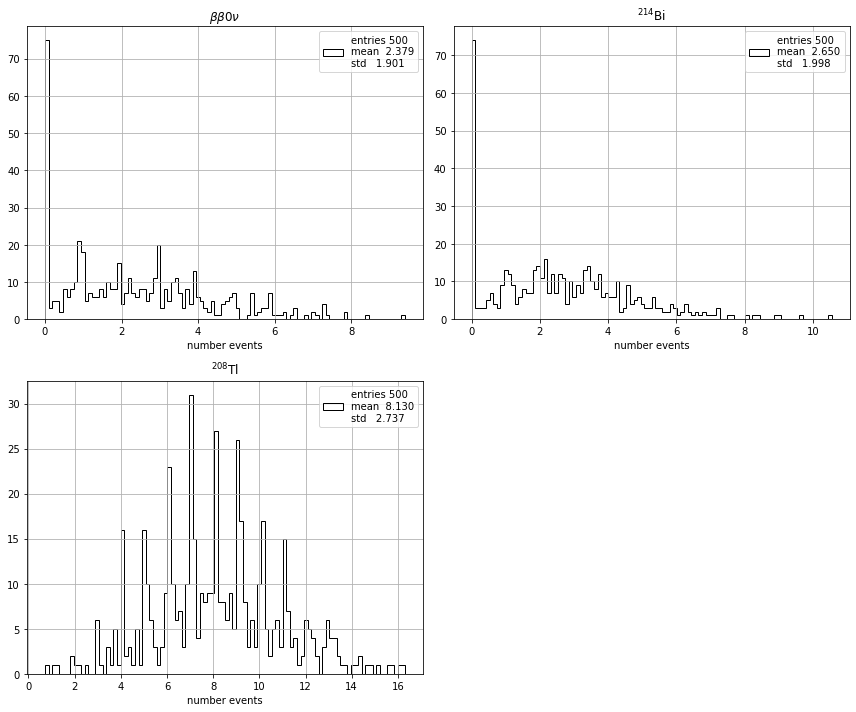

In [18]:
size      = 500
nbb_roi   = 1. * nevts_Bi_RoI
nevts_fit = (nbb_roi, nevts_Bi * eff_Bi_fit, nevts_Tl * eff_Tl_fit)
nevts     = (nbb_roi/eff_bb_RoI, nevts_Bi, nevts_Tl)
print('Total events           :', *nevts)
print('Expected Events in fit :', *nevts_fit)
mevts   = experiments(mcs, size, nevts)

Total events           : 2.2071290944123314 147.773 1116.288
Expected Events in fit : 1.1455 2.6591479296823075 8.145218617278994


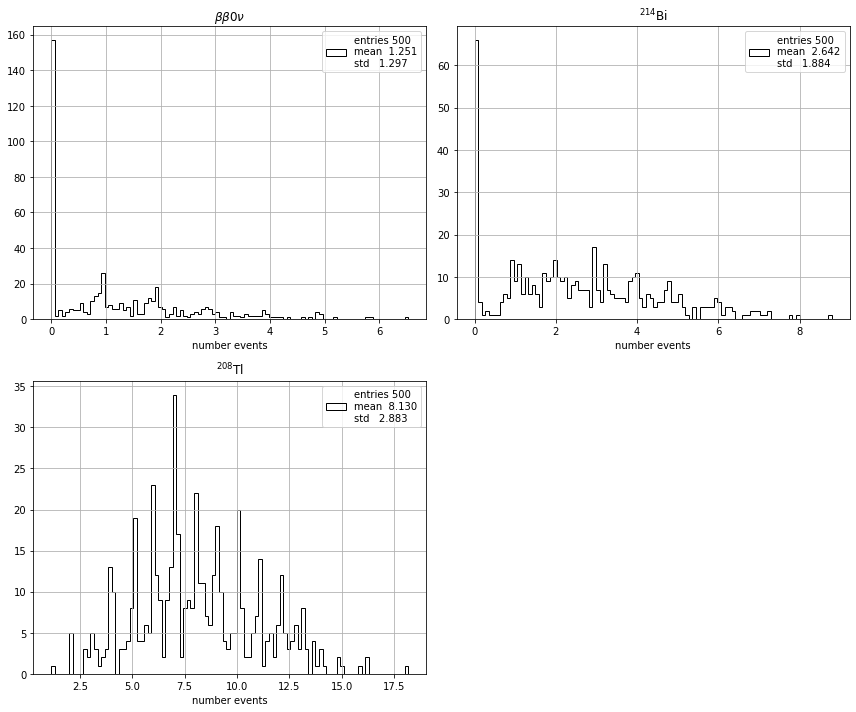

In [19]:
size      = 500
nbb_roi   = 0.5 * nevts_Bi_RoI
nevts_fit = (nbb_roi, nevts_Bi * eff_Bi_fit, nevts_Tl * eff_Tl_fit)
nevts     = (nbb_roi/eff_bb_RoI, nevts_Bi, nevts_Tl)
print('Total events           :', *nevts)
print('Expected Events in fit :', *nevts_fit)
mevts   = experiments(mcs, size, nevts)

## Estimate the half-time

In [20]:
from collpars import exposure

nevts_bb_RoI = nevts_Bi_RoI
acc_bb       = 0.794
eff          = acc_bb * eff_bb_RoI
tau          = fn.half_life(nevts_bb_RoI, exposure, eff)

print('number of bb0nu events  : {:6.3f}'.format(nevts_bb_RoI))
print('exposure                : {:6.2f} kg y'.format(exposure))
print('total signal efficiency : {:6.3f}'.format(eff))
print('bb0nu half-life         : {:6.2e} y '.format(tau))

number of bb0nu events  :  2.291
exposure                : 500.00 kg y
total signal efficiency :  0.412
bb0nu half-life         : 2.49e+26 y 
